This notebook further evaluates our best model for best features for profitability. We will start with our basic model and add features to see the impact of feature addition on performance matrices

In [1]:
## Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import  RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score

pd.options.display.float_format = '{:,.2f}'.format
pd.pandas.set_option('display.max_rows', None)
pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # Set to None to display full content of each column

np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")


In [2]:
## Read data
df = pd.read_csv('../Data/final_inflation_adj_data.csv')


In [3]:
## Filter data from after the Netflix launch and before 2020 to prevent the outliers

df = df[(df['year']>=2007)&(df['year']<2020)]

In [4]:
df.columns

Index(['name', 'rating', 'genre', 'year', 'score', 'votes', 'director',
       'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime',
       'month', 'rating_imputed', 'budget_imputed', 'inf_adjmnt_value',
       'budget_adj', 'gross_adj', 'profit', 'profit_adj'],
      dtype='object')

In [5]:
# Define the features and the target variable

X = df.drop(['name', 'gross', 'profit', 'profit_adj', 'gross_adj', 'rating_imputed', 'budget_imputed','inf_adjmnt_value'], axis=1)
y = df['profit_adj']


In [6]:
# Define numerical and categorical columns to be used in model for feature evaluation

numerical_cols = ['rating', 'runtime', 'budget_adj']
categorical_cols = ['genre', 'company', 'country'] ##'director', 'writer', 'star', 'country', 'month', 'star' 

X=df[categorical_cols + numerical_cols]
y= df['profit_adj']

In [7]:

#instantiae OnehotEncoder
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = True)

#preprocessing steps
ss = StandardScaler()
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)
ctx = ColumnTransformer(
                            transformers = [
                                 ('one_hot', ohe, categorical_cols ),
                                 ('sc',  ss,   numerical_cols)
                                ] 
                                   , verbose_feature_names_out=False
                                    , remainder='passthrough'
                        
                            ) 


In [8]:
#split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state =42)


## fit and transform training data

X_train = ctx.fit_transform(X_train)
X_train =pd.DataFrame(X_train, columns=ctx.get_feature_names_out())

##transform test data

X_test = ctx.transform(X_test)
X_test =pd.DataFrame(X_test, columns=ctx.get_feature_names_out())

X_train.shape, X_test.shape

((1941, 832), (648, 832))

In [9]:
#Lists to hold result metrices

Features=[]
Train_r2 = []
Test_r2 =[]
RMSE =[]
CV_score =[]

#### Random Forest Regressor

Grid Searching for best parameters

In [10]:
#Instantiate Grid search pipeline for Random Forest Regression

pipe_rf = Pipeline([('rf', RandomForestRegressor())]
                   )
params = {
            'rf__n_estimators': [50, 100, 200],
            'rf__max_features': ['auto', 'sqrt', 'log2']
         }

gs_rf = GridSearchCV(pipe_rf, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_features': ['auto', 'sqrt', 'log2'],
                         'rf__n_estimators': [50, 100, 200]},
             scoring='r2')

In [11]:
y_pred_rf = gs_rf.best_estimator_.predict(X_test)


print(f'Train rsquare: {gs_rf.score(X_train, y_train)}')
print(f'Test rsquare: {gs_rf.score(X_test, y_test)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred_rf)}')
print(f'Best CV score: {gs_rf.best_score_}')
print(f'Best Parameters: {gs_rf.best_params_}')

Features.append(categorical_cols + numerical_cols)
Train_r2.append(gs_rf.score(X_train, y_train))
Test_r2.append(gs_rf.score(X_test, y_test))
RMSE.append(root_mean_squared_error(y_test, y_pred_rf))
CV_score.append(gs_rf.best_score_)

Train rsquare: 0.9259023626175678
Test rsquare: 0.4723513209831206
RMSE: 154772928.89281854
Best CV score: 0.4616909157091609
Best Parameters: {'rf__max_features': 'log2', 'rf__n_estimators': 100}


In [12]:
# Instantiate Random Forest regressor with best parameters from gridsearch 

rf = RandomForestRegressor(n_estimators=200, max_features='sqrt', random_state=42)

# fit the model on the training data
rf.fit(X_train, y_train)

# get feature importances from the trained random forest regressor

feature_importances = rf.feature_importances_

# Create a DataFrame for better visualization of Features

features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})


In [13]:
features['Importance'].sum()

0.9999999999999996

In [14]:
features = features.sort_values(by='Importance', ascending=False)

In [15]:
top_20_features = features.head(20)

In [16]:
top_20_features

,Feature,Importance
831,budget_adj,0.35
830,runtime,0.21
829,rating,0.06
510,company_Marvel Studios,0.04
1,genre_Animation,0.03
727,company_Twentieth Century Fox,0.02
755,company_Walt Disney Pictures,0.02
739,company_Universal Pictures,0.01
827,country_United States,0.01
428,company_Illumination Entertainment,0.01


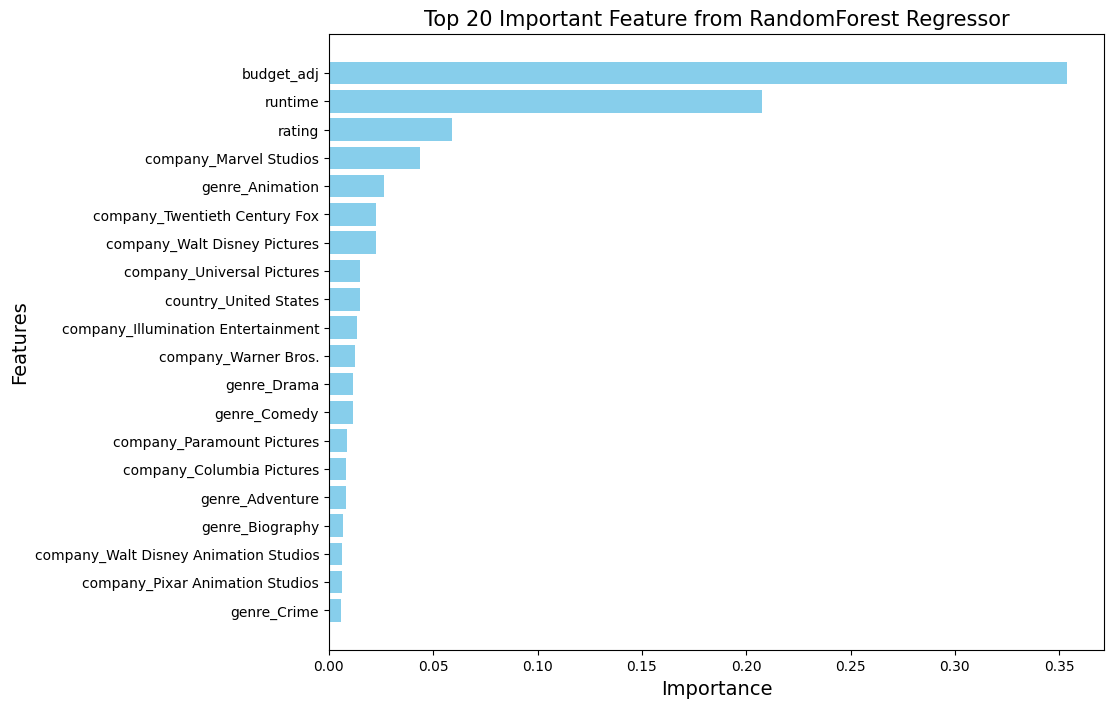

In [17]:
# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize =14)
plt.ylabel('Features', fontsize =14)
plt.title('Top 20 Important Feature from RandomForest Regressor', fontsize =15)
plt.gca().invert_yaxis()
plt.show()

### Adding Month Feature

In [18]:
# Re-define numerical and categorical columns adding month feature

numerical_cols = ['rating', 'runtime', 'budget_adj']
categorical_cols = ['genre', 'company','country', 'month'] ##'director', 'writer', 'star', 'country', 'month', 'star' 

#instantiae OnehotEncoder
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = True)

#preprocessing steps
ss = StandardScaler()
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)
ctx = ColumnTransformer(
                            transformers = [
                                 ('one_hot', ohe, categorical_cols ),
                                 ('sc',  ss,   numerical_cols)
                                ] 
                                   , verbose_feature_names_out=False
                                    , remainder='passthrough'
                        
                            ) 

In [19]:

X=df[categorical_cols + numerical_cols]
y= df['profit_adj']

# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state =42)
X_train.shape, X_test.shape

## fit and transform training  and test data

X_train = ctx.fit_transform(X_train)
X_train =pd.DataFrame(X_train, columns=ctx.get_feature_names_out())

X_test = ctx.transform(X_test)
X_test =pd.DataFrame(X_test, columns=ctx.get_feature_names_out())


In [20]:
#Instantiate Grid search pipeline for Random Forest Regression

pipe_rf = Pipeline([('rf', RandomForestRegressor())]
                   )
params = {
            'rf__n_estimators': [50, 100, 200],
            'rf__max_features': ['auto', 'sqrt', 'log2']
         }

gs_rf = GridSearchCV(pipe_rf, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
gs_rf.fit(X_train, y_train)


y_pred_rf = gs_rf.best_estimator_.predict(X_test)

print(f'Train rsquare: {gs_rf.score(X_train, y_train)}')
print(f'Test rsquare: {gs_rf.score(X_test, y_test)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred_rf)}')
print(f'Best CV score: {gs_rf.best_score_}')
print(f'Best Parameters: {gs_rf.best_params_}')

Features.append(categorical_cols + numerical_cols)
Train_r2.append(gs_rf.score(X_train, y_train))
Test_r2.append(gs_rf.score(X_test, y_test))
RMSE.append(root_mean_squared_error(y_test, y_pred_rf))
CV_score.append(gs_rf.best_score_)

Train rsquare: 0.9360551163442749
Test rsquare: 0.5080275019874199
RMSE: 149448990.71882367
Best CV score: 0.4798415770089407
Best Parameters: {'rf__max_features': 'sqrt', 'rf__n_estimators': 200}


In [21]:
# Instantiate Random Forest regressor with best parameters from gridsearch 

rf = RandomForestRegressor(n_estimators=200, max_features='sqrt', random_state=42)

rf.fit(X_train, y_train)

# get feature importances from the trained random forest regressor

feature_importances = rf.feature_importances_

# Create a DataFrame for better visualization of Features

features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
features = features.sort_values(by='Importance', ascending=False)
top_20_features = features.head(20)
top_20_features

,Feature,Importance
842,budget_adj,0.28
841,runtime,0.17
840,rating,0.06
510,company_Marvel Studios,0.05
727,company_Twentieth Century Fox,0.03
1,genre_Animation,0.03
755,company_Walt Disney Pictures,0.02
739,company_Universal Pictures,0.02
834,month_June,0.02
827,country_United States,0.02


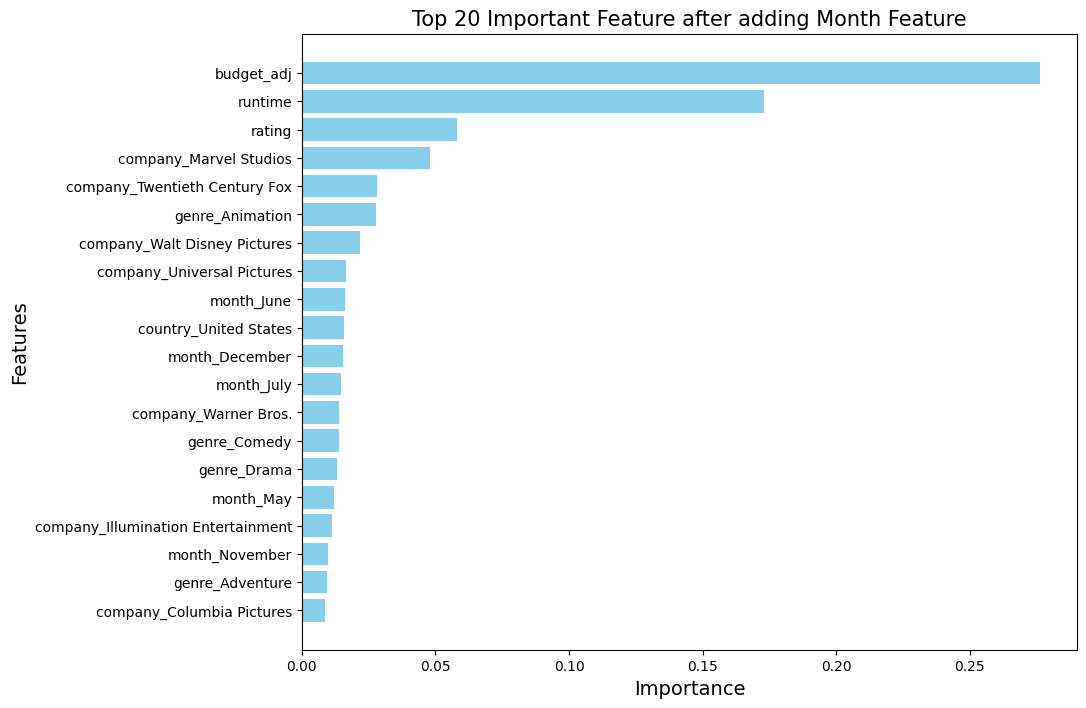

In [22]:
# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize =14)
plt.ylabel('Features', fontsize =14)
plt.title('Top 20 Important Feature after adding Month Feature', fontsize =15)
plt.gca().invert_yaxis()
plt.show()

### Adding `Star` Feature for model evaluation. This feature decreases RMSE and increswes CV_Score and R2scores.

In [23]:
# star feature added

numerical_cols = ['rating', 'runtime', 'budget_adj']
categorical_cols = ['genre', 'company','country', 'month', 'star'] ##'director', 'writer',  

#instantiae OnehotEncoder
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = True)

#preprocessing steps
ss = StandardScaler()
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)
ctx = ColumnTransformer(
                            transformers = [
                                 ('one_hot', ohe, categorical_cols ),
                                 ('sc',  ss,   numerical_cols)
                                ] 
                                   , verbose_feature_names_out=False
                                    , remainder='passthrough'
                        
                            ) 

X=df[categorical_cols + numerical_cols]
y= df['profit_adj']

# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state =42)
X_train.shape, X_test.shape

## fit and transform training  and test data

X_train = ctx.fit_transform(X_train)
X_train =pd.DataFrame(X_train, columns=ctx.get_feature_names_out())


X_test = ctx.transform(X_test)
X_test =pd.DataFrame(X_test, columns=ctx.get_feature_names_out())


In [24]:
#Instantiate Grid search pipeline for Random Forest Regression

pipe_rf = Pipeline([('rf', RandomForestRegressor())]
                   )
params = {
            'rf__n_estimators': [50, 100, 200],
            'rf__max_features': ['auto', 'sqrt', 'log2']
         }

gs_rf = GridSearchCV(pipe_rf, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
gs_rf.fit(X_train, y_train)

y_pred_rf = gs_rf.best_estimator_.predict(X_test)
print(f'Train rsquare: {gs_rf.score(X_train, y_train)}')
print(f'Test rsquare: {gs_rf.score(X_test, y_test)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred_rf)}')
print(f'Best CV score: {gs_rf.best_score_}')
print(f'Best Parameters: {gs_rf.best_params_}')

Features.append(categorical_cols + numerical_cols)
Train_r2.append(gs_rf.score(X_train, y_train))
Test_r2.append(gs_rf.score(X_test, y_test))
RMSE.append(root_mean_squared_error(y_test, y_pred_rf))
CV_score.append(gs_rf.best_score_)

Train rsquare: 0.936223765306299
Test rsquare: 0.5769815784424502
RMSE: 138580528.66341844
Best CV score: 0.5220595548456423
Best Parameters: {'rf__max_features': 'sqrt', 'rf__n_estimators': 200}


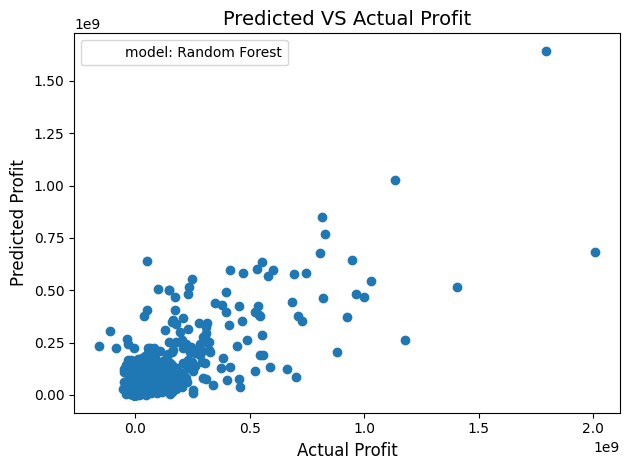

In [25]:
# plot ypred vs ytrue
plt.Figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf)
plt.title('Predicted VS Actual Profit',fontsize=14)
plt.xlabel('Actual Profit',fontsize=12)
plt.ylabel('Predicted Profit',fontsize=12)

plt.plot([], [], ' ', label="model: Random Forest")
plt.legend()
plt.tight_layout()
plt.savefig('../images/predicted_vs_actual_profit.png');

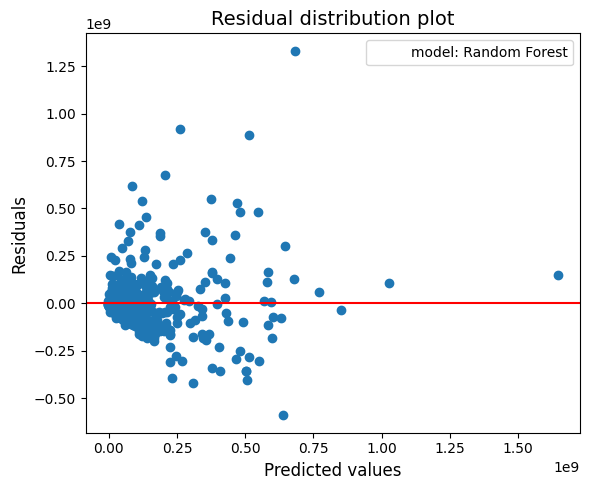

In [26]:
residuals = y_test - y_pred_rf
# plot residuals
plt.rcParams['figure.figsize'] = (6.0, 5.0)
plt.scatter(y_pred_rf, residuals)
plt.axhline(0, linestyle='-', color='r')
plt.title('Residual distribution plot',fontsize=14)
plt.xlabel('Predicted values',fontsize=12)
plt.ylabel('Residuals',fontsize=12)
plt.plot([], [], ' ', label="model: Random Forest")
plt.legend()
plt.tight_layout()
plt.savefig('../images/residual_distribution_plot.png');

In [27]:
# Instantiate Random Forest regressor with best parameters from gridsearch 

rf = RandomForestRegressor(n_estimators=200, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
features = features.sort_values(by='Importance', ascending=False)
top_20_features = features.head(20)
top_20_features


,Feature,Importance
1835,budget_adj,0.21
1834,runtime,0.10
1833,rating,0.04
510,company_Marvel Studios,0.04
1658,star_Sam Worthington,0.03
1623,star_Robert Downey Jr.,0.02
1,genre_Animation,0.02
1003,star_Chris Pratt,0.02
727,company_Twentieth Century Fox,0.02
755,company_Walt Disney Pictures,0.02


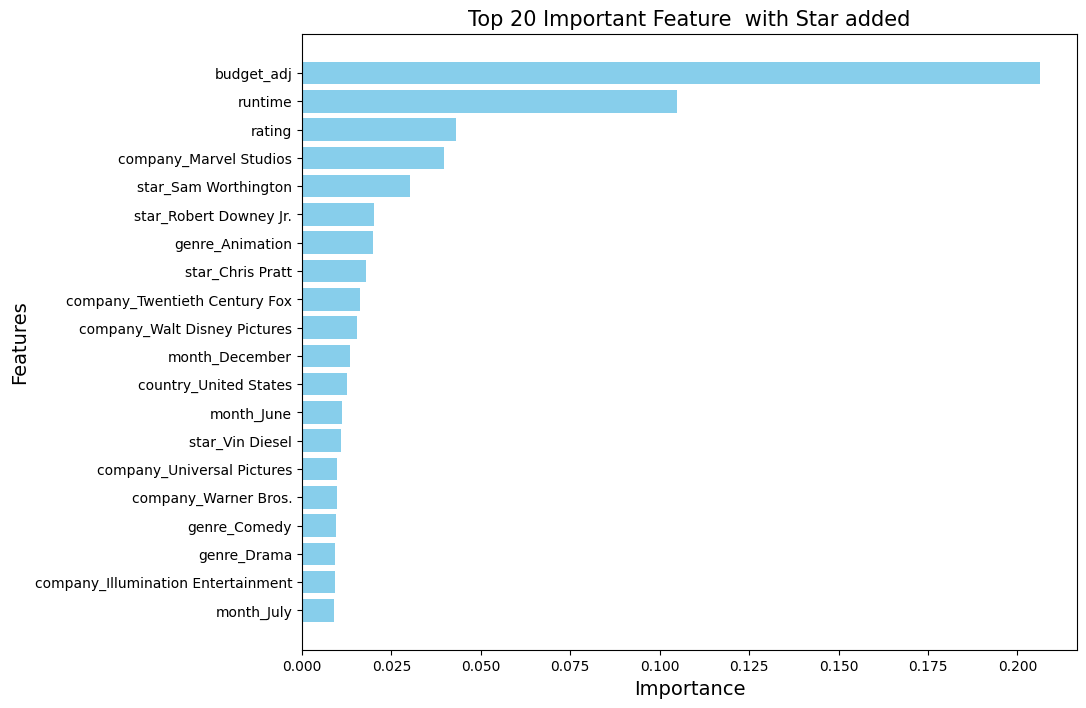

<Figure size 600x500 with 0 Axes>

In [28]:
# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize =14)
plt.ylabel('Features', fontsize =14)
plt.title('Top 20 Important Feature  with Star added', fontsize =15)
plt.gca().invert_yaxis()
plt.show()
plt.savefig('../Images/top_20_important_feature_with_Star_added.png', dpi = 192);

#### Budget_adj has the highest importance score indicating that the adjusted budgete of a movie is the most influential factor predicting the profit. This makes sense because the budget often determines the scale of production marketing efforts and overall quality which can significatntly impact a movie's succsess. Second most important feature is runtime. This could be because the length of movie can affect its appeal to various audiences and its abiliy to tell compelling story. 

### Adding Director Feature

In [29]:
# director feature added

numerical_cols = ['rating', 'runtime', 'budget_adj']
categorical_cols = ['genre', 'company','country', 'month', 'star', 'director'] 

#instantiae OnehotEncoder
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = True)

#preprocessing steps
ss = StandardScaler()
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)
ctx = ColumnTransformer(
                            transformers = [
                                 ('one_hot', ohe, categorical_cols ),
                                 ('sc',  ss,   numerical_cols)
                                ] 
                                   , verbose_feature_names_out=False
                                    , remainder='passthrough'
                        
                            ) 

X=df[categorical_cols + numerical_cols]
y= df['profit_adj']

# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state =42)
X_train.shape, X_test.shape

## fit and transform training  and test data

X_train = ctx.fit_transform(X_train)
X_train =pd.DataFrame(X_train, columns=ctx.get_feature_names_out())


X_test = ctx.transform(X_test)
X_test =pd.DataFrame(X_test, columns=ctx.get_feature_names_out())

In [30]:
#Instantiate Grid search pipeline for Random Forest Regression

pipe_rf = Pipeline([('rf', RandomForestRegressor())]
                   )
params = {
            'rf__n_estimators': [50, 100, 200],
            'rf__max_features': ['auto', 'sqrt', 'log2']
         }

gs_rf = GridSearchCV(pipe_rf, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
gs_rf.fit(X_train, y_train)

y_pred_rf = gs_rf.best_estimator_.predict(X_test)
print(f'Train rsquare: {gs_rf.score(X_train, y_train)}')
print(f'Test rsquare: {gs_rf.score(X_test, y_test)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred_rf)}')
print(f'Best CV score: {gs_rf.best_score_}')
print(f'Best Parameters: {gs_rf.best_params_}')

Features.append(categorical_cols + numerical_cols)
Train_r2.append(gs_rf.score(X_train, y_train))
Test_r2.append(gs_rf.score(X_test, y_test))
RMSE.append(root_mean_squared_error(y_test, y_pred_rf))
CV_score.append(gs_rf.best_score_)

Train rsquare: 0.9329283549371183
Test rsquare: 0.5775262682222639
RMSE: 138491279.93563193
Best CV score: 0.5137848616008339
Best Parameters: {'rf__max_features': 'sqrt', 'rf__n_estimators': 100}


In [31]:
# Instantiate Random Forest regressor with best parameters from gridsearch 

rf = RandomForestRegressor(n_estimators=200, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
features = features.sort_values(by='Importance', ascending=False)
top_20_features = features.head(20)
top_20_features


,Feature,Importance
3020,budget_adj,0.16
3019,runtime,0.07
3018,rating,0.03
2293,director_James Cameron,0.03
510,company_Marvel Studios,0.03
1658,star_Sam Worthington,0.02
1,genre_Animation,0.02
1623,star_Robert Downey Jr.,0.02
1907,director_Anthony Russo,0.02
1003,star_Chris Pratt,0.01


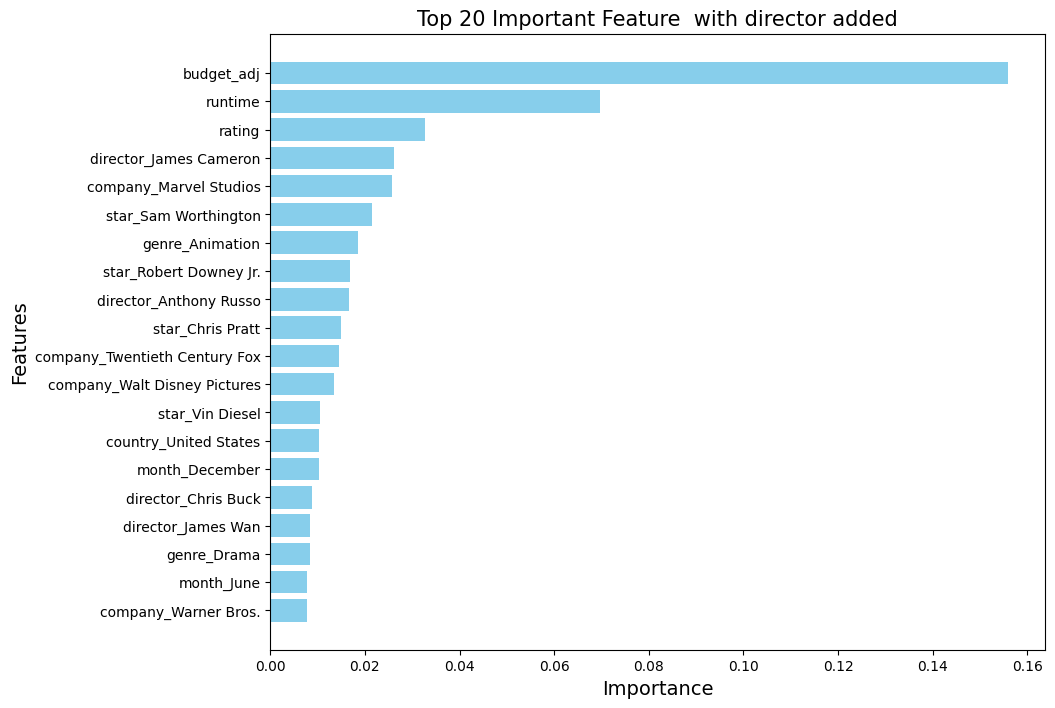

In [32]:
# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize =14)
plt.ylabel('Features', fontsize =14)
plt.title('Top 20 Important Feature  with director added', fontsize =15)
plt.gca().invert_yaxis()
plt.show()

#### Adding `Writer` feature to see the impact

In [33]:
# writer feature added

numerical_cols = ['rating', 'runtime', 'budget_adj']
categorical_cols = ['genre', 'company','country', 'month', 'star', 'director','writer']  

#instantiae OnehotEncoder
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = True)

#preprocessing steps
ss = StandardScaler()
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)
ctx = ColumnTransformer(
                            transformers = [
                                 ('one_hot', ohe, categorical_cols ),
                                 ('sc',  ss,   numerical_cols)
                                ] 
                                   , verbose_feature_names_out=False
                                    , remainder='passthrough'
                        
                            ) 

X=df[categorical_cols + numerical_cols]
y= df['profit_adj']

# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state =42)
X_train.shape, X_test.shape

## fit and transform training  and test data

X_train = ctx.fit_transform(X_train)
X_train =pd.DataFrame(X_train, columns=ctx.get_feature_names_out())


X_test = ctx.transform(X_test)
X_test =pd.DataFrame(X_test, columns=ctx.get_feature_names_out())

In [34]:
#Instantiate Grid search pipeline for Random Forest Regression

pipe_rf = Pipeline([('rf', RandomForestRegressor())]
                   )
params = {
            'rf__n_estimators': [50, 100, 200],
            'rf__max_features': ['auto', 'sqrt', 'log2']
         }

gs_rf = GridSearchCV(pipe_rf, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
gs_rf.fit(X_train, y_train)


y_pred_rf = gs_rf.best_estimator_.predict(X_test)
print(f'Train rsquare: {gs_rf.score(X_train, y_train)}')
print(f'Test rsquare: {gs_rf.score(X_test, y_test)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred_rf)}')
print(f'Best CV score: {gs_rf.best_score_}')
print(f'Best Parameters: {gs_rf.best_params_}')

Features.append(categorical_cols + numerical_cols)
Train_r2.append(gs_rf.score(X_train, y_train))
Test_r2.append(gs_rf.score(X_test, y_test))
RMSE.append(root_mean_squared_error(y_test, y_pred_rf))
CV_score.append(gs_rf.best_score_)

Train rsquare: 0.9353494794504794
Test rsquare: 0.5489624215040803
RMSE: 143096475.47182214
Best CV score: 0.4879818155920157
Best Parameters: {'rf__max_features': 'sqrt', 'rf__n_estimators': 200}


In [35]:
# Instantiate Random Forest regressor with best parameters from gridsearch 

rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
features = features.sort_values(by='Importance', ascending=False)
top_20_features = features.head(20)
top_20_features


,Feature,Importance
4424,budget_adj,0.14
4423,runtime,0.06
3555,writer_James Cameron,0.02
4422,rating,0.02
510,company_Marvel Studios,0.02
2293,director_James Cameron,0.02
1907,director_Anthony Russo,0.02
1623,star_Robert Downey Jr.,0.02
1,genre_Animation,0.01
1658,star_Sam Worthington,0.01


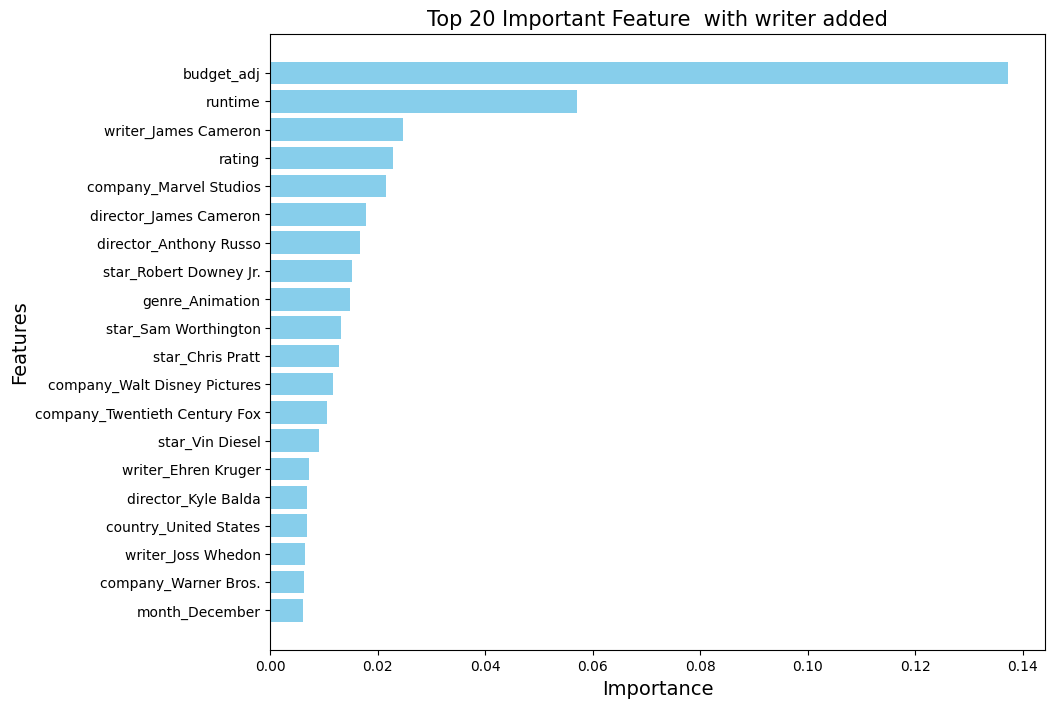

In [36]:
# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize =14)
plt.ylabel('Features', fontsize =14)
plt.title('Top 20 Important Feature  with writer added', fontsize =15)
plt.gca().invert_yaxis()
plt.show()

#### Trying to see model performance with categorical columns `genre` `company` `month`

In [37]:
# Removing country and keeping only 'genre', 'company', 'month'

numerical_cols = ['rating', 'runtime', 'budget_adj']
categorical_cols = ['genre', 'company', 'month'] 

#instantiae OnehotEncoder
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = True)

#preprocessing steps
ss = StandardScaler()
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)
ctx = ColumnTransformer(
                            transformers = [
                                 ('one_hot', ohe, categorical_cols ),
                                 ('sc',  ss,   numerical_cols)
                                ] 
                                   , verbose_feature_names_out=False
                                    , remainder='passthrough'
                        
                            ) 

X=df[categorical_cols + numerical_cols]
y= df['profit_adj']

# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state =42)
X_train.shape, X_test.shape

## fit and transform training  and test data

X_train = ctx.fit_transform(X_train)
X_train =pd.DataFrame(X_train, columns=ctx.get_feature_names_out())


X_test = ctx.transform(X_test)
X_test =pd.DataFrame(X_test, columns=ctx.get_feature_names_out())

In [38]:
#Instantiate Grid search pipeline for Random Forest Regression

pipe_rf = Pipeline([('rf', RandomForestRegressor())]
                   )
params = {
            'rf__n_estimators': [50, 100, 200],
            'rf__max_features': ['auto', 'sqrt', 'log2']
         }

gs_rf = GridSearchCV(pipe_rf, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
gs_rf.fit(X_train, y_train)

y_pred_rf = gs_rf.best_estimator_.predict(X_test)
print(f'Train rsquare: {gs_rf.score(X_train, y_train)}')
print(f'Test rsquare: {gs_rf.score(X_test, y_test)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred_rf)}')
print(f'Best CV score: {gs_rf.best_score_}')
print(f'Best Parameters: {gs_rf.best_params_}')

Features.append(categorical_cols + numerical_cols)
Train_r2.append(gs_rf.score(X_train, y_train))
Test_r2.append(gs_rf.score(X_test, y_test))
RMSE.append(root_mean_squared_error(y_test, y_pred_rf))
CV_score.append(gs_rf.best_score_)

Train rsquare: 0.9311639906789788
Test rsquare: 0.4971802583925339
RMSE: 151087569.13316643
Best CV score: 0.4781361498752544
Best Parameters: {'rf__max_features': 'sqrt', 'rf__n_estimators': 200}


In [39]:
# Instantiate Random Forest regressor with best parameters from gridsearch 

rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
features = features.sort_values(by='Importance', ascending=False)
top_20_features = features.head(20)
top_20_features


,Feature,Importance
798,budget_adj,0.30
797,runtime,0.17
796,rating,0.06
510,company_Marvel Studios,0.05
727,company_Twentieth Century Fox,0.03
1,genre_Animation,0.02
755,company_Walt Disney Pictures,0.02
739,company_Universal Pictures,0.02
786,month_December,0.02
790,month_June,0.02


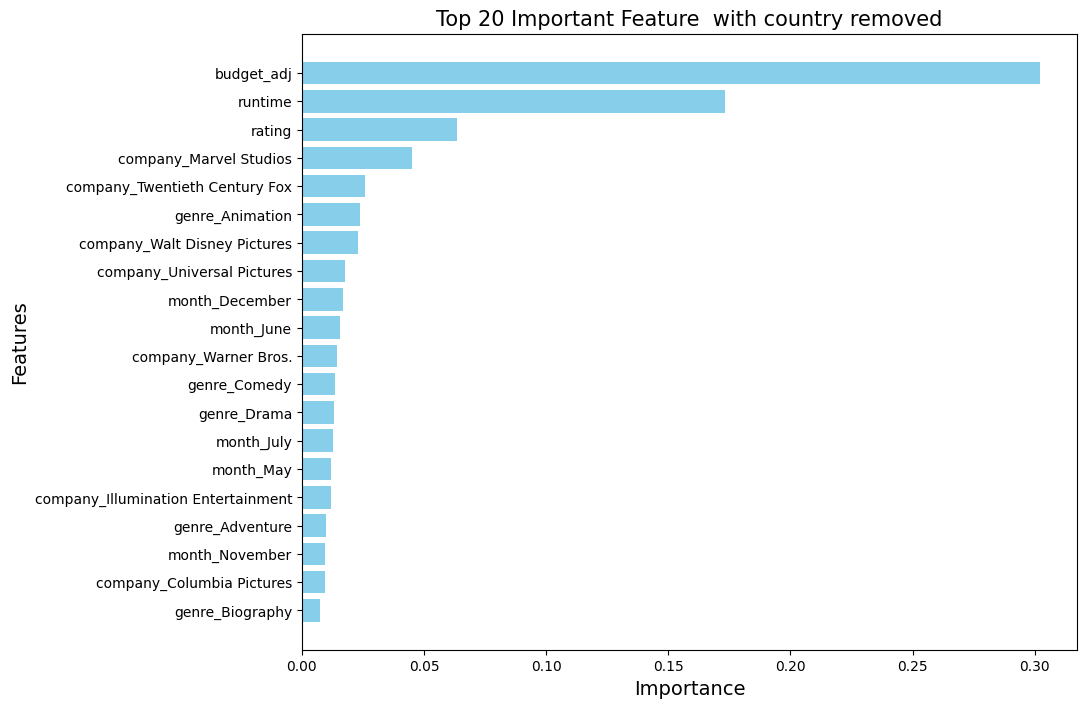

In [40]:
# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize =14)
plt.ylabel('Features', fontsize =14)
plt.title('Top 20 Important Feature  with country removed', fontsize =15)
plt.gca().invert_yaxis()
plt.show()

In [41]:
# Removing  'Budget'

numerical_cols = ['rating', 'runtime' ]
categorical_cols = ['genre', 'company', 'month','star' ,'director'] 

#instantiae OnehotEncoder
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = True)

#preprocessing steps
ss = StandardScaler()
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)
ctx = ColumnTransformer(
                            transformers = [
                                 ('one_hot', ohe, categorical_cols ),
                                 ('sc',  ss,   numerical_cols)
                                ] 
                                   , verbose_feature_names_out=False
                                    , remainder='passthrough'
                        
                            ) 

X=df[categorical_cols + numerical_cols]
y= df['profit_adj']

# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state =42)
X_train.shape, X_test.shape

## fit and transform training  and test data

X_train = ctx.fit_transform(X_train)
X_train =pd.DataFrame(X_train, columns=ctx.get_feature_names_out())


X_test = ctx.transform(X_test)
X_test =pd.DataFrame(X_test, columns=ctx.get_feature_names_out())

In [42]:
#Instantiate Grid search pipeline for Random Forest Regression

pipe_rf = Pipeline([('rf', RandomForestRegressor())]
                   )
params = {
            'rf__n_estimators': [50, 100, 200],
            'rf__max_features': ['auto', 'sqrt', 'log2']
         }

gs_rf = GridSearchCV(pipe_rf, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
gs_rf.fit(X_train, y_train)

y_pred_rf = gs_rf.best_estimator_.predict(X_test)
print(f'Train rsquare: {gs_rf.score(X_train, y_train)}')
print(f'Test rsquare: {gs_rf.score(X_test, y_test)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred_rf)}')
print(f'Best CV score: {gs_rf.best_score_}')
print(f'Best Parameters: {gs_rf.best_params_}')

Features.append(categorical_cols + numerical_cols)
Train_r2.append(gs_rf.score(X_train, y_train))
Test_r2.append(gs_rf.score(X_test, y_test))
RMSE.append(root_mean_squared_error(y_test, y_pred_rf))
CV_score.append(gs_rf.best_score_)

Train rsquare: 0.928316912337587
Test rsquare: 0.5154013605716319
RMSE: 148324764.95677948
Best CV score: 0.452807989847804
Best Parameters: {'rf__max_features': 'sqrt', 'rf__n_estimators': 200}


In [43]:
# Instantiate Random Forest regressor with best parameters from gridsearch 

rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
features = features.sort_values(by='Importance', ascending=False)
top_20_features = features.head(20)
top_20_features


,Feature,Importance
2975,runtime,0.09
2974,rating,0.05
510,company_Marvel Studios,0.04
2249,director_James Cameron,0.04
1579,star_Robert Downey Jr.,0.02
1,genre_Animation,0.02
1614,star_Sam Worthington,0.02
727,company_Twentieth Century Fox,0.02
755,company_Walt Disney Pictures,0.02
959,star_Chris Pratt,0.02


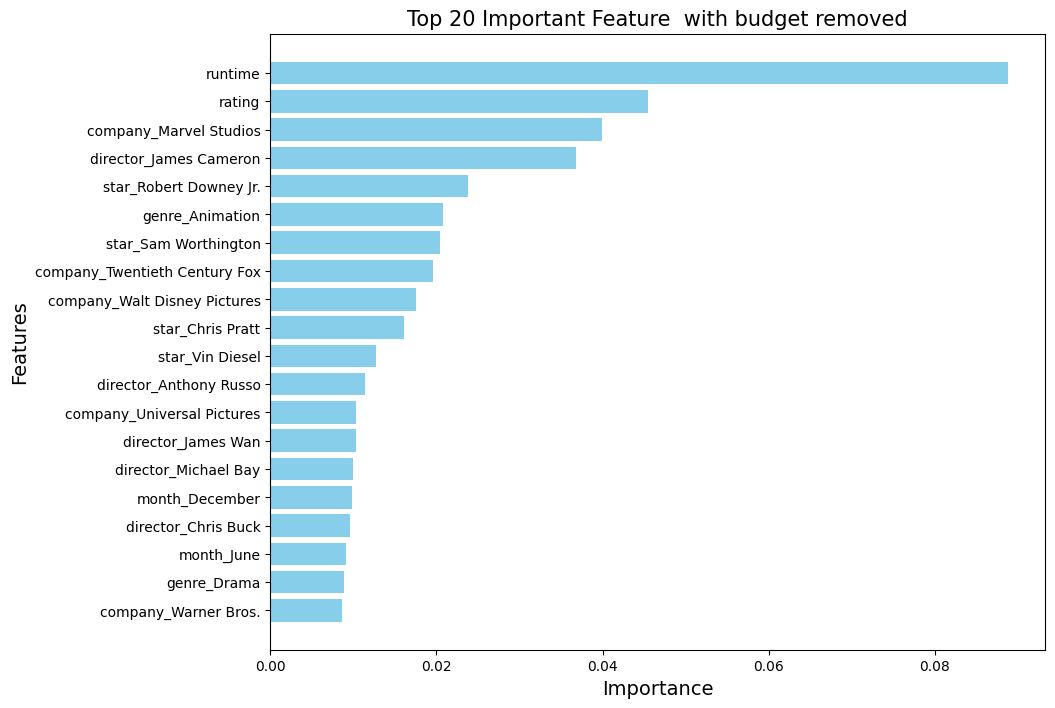

In [44]:
# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize =14)
plt.ylabel('Features', fontsize =14)
plt.title('Top 20 Important Feature  with budget removed', fontsize =15)
plt.gca().invert_yaxis()
plt.show()

In [45]:
Train_r2 = [round(num, 4) for num in Train_r2]
Test_r2 = [round(num, 4) for num in Test_r2]
RMSE = [f'{num:,.2f}' for num in RMSE]  # Format with comma and 2 decimal places
CV_score = [round(num, 4) for num in CV_score]

In [46]:
# Create DataFrame
data = {'Features': Features, 'Train_r2': Train_r2, 'Test_r2': Test_r2, 'RMSE': RMSE, 'CV_score': CV_score}
result = pd.DataFrame(data)


In [47]:
result.sort_values(by='RMSE')

,Features,Train_r2,Test_r2,RMSE,CV_score
3,"[genre, company, country, month, star, director, rating, runtime, budget_adj]",0.93,0.58,"138,491,279.94",0.51
2,"[genre, company, country, month, star, rating, runtime, budget_adj]",0.94,0.58,"138,580,528.66",0.52
4,"[genre, company, country, month, star, director, writer, rating, runtime, budget_adj]",0.94,0.55,"143,096,475.47",0.49
6,"[genre, company, month, star, director, rating, runtime]",0.93,0.52,"148,324,764.96",0.45
1,"[genre, company, country, month, rating, runtime, budget_adj]",0.94,0.51,"149,448,990.72",0.48
5,"[genre, company, month, rating, runtime, budget_adj]",0.93,0.50,"151,087,569.13",0.48
0,"[genre, company, country, rating, runtime, budget_adj]",0.93,0.47,"154,772,928.89",0.46


#### The feature sets `genre`, `company`, `country`, `month`, `star`, `rating`, `runtime`and  `budget_adj` are the most important as it provides least RMSE and hgihest Teast and Train R2 and CVScore.Adding the features star and month seems to improve the model's performance compared to other features sets. 